In [ ]:
 # link drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import packages
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
import pickle
import csv
import pandas as pd

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# get training data 
train_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/340W_Project/data/train.tsv', sep='\t', header=0)
train_pid = train_data['PhraseId'].tolist()
train_sid = train_data['SentenceId'].tolist()
train_phrase = train_data['Phrase'].tolist()
train_y = train_data['Sentiment'].tolist()
train_data

# repeat this same process for the test data
# recall that there is no sentiment column here
test_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/340W_Project/data/test.tsv', sep='\t', header=0)
test_pid = test_data['PhraseId'].tolist()
test_sid = test_data['SentenceId'].tolist()
test_phrase = test_data['Phrase'].tolist()
test_data

print('Loaded dataset with {} training samples, {} test samples'.format(len(train_phrase), len(test_phrase)))

Loaded dataset with 156060 training samples, 66292 test samples


In [ ]:
print('---review---')
print(train_phrase[0])
print('---label---')
print(train_y[0])

---review---
A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .
---label---
1


In [ ]:
from nltk.corpus import stopwords

def phrase_preprocessor(phrases):
  stemmer = WordNetLemmatizer()

  processed_phrases = []

  for sen in range(len(phrases)):
    # remove special chars
    phrase = re.sub(r'\W', ' ', str(phrases[sen]))

    # remove all single characters
    phrase = re.sub(r'\s+[a-zA-Z]\s+', ' ', phrase)

    # removes single characters from start of phrase
    phrase = re.sub(r'\^[a-zA-Z]\s+', ' ', phrase) 

    # replace multiple spaces with a single space
    phrase = re.sub(r'\s+', ' ', phrase, flags=re.I)

    # make the phrase all lowercse
    phrase = phrase.lower()

    # lemmatization (i.e. remove small differences that dont't matter)
    # Ex: "cats" -> "cat"
    phrase = phrase.split()
    phrase = [stemmer.lemmatize(w) for w in phrase if not w in set(stopwords.words('english'))]
    # phrase = [stemmer.lemmatize(w) for w in phrase]
    phrase = ' '.join(phrase)

    # append to output list
    processed_phrases.append(phrase)

  return processed_phrases

# add a column of these processed phrases for both the train and test data
test_processed = phrase_preprocessor(test_phrase)
train_processed = phrase_preprocessor(train_phrase)

print('---review---')
print(train_processed[0])
print('---label---')
print(train_y[0])

---review---
series escapade demonstrating adage good goose also good gander occasionally amuses none amount much story
---label---
1


In [ ]:
# tokenize all words into numbers

n_words = 15000

train_tokens = []
test_tokens = []
tokens = {}
value = 1
total_phrases = train_processed + test_processed
for phrase in total_phrases:
  for word in phrase.split():
    if word not in tokens:
      tokens.update({word: value})
      value += 1
# set words greater than n_words to 0
for word in tokens:
  if tokens[word] > n_words:
    tokens.update({word: 0})
# tokenized train
for phrase in train_processed:
  tmp = []
  for word in phrase.split():
    tmp.append(tokens[word])
  train_tokens.append(tmp)
# tokenized test
for phrase in test_processed:
  tmp = []
  for word in phrase.split():
    tmp.append(tokens[word])
  test_tokens.append(tmp)

# view results
print('---review---')
print(train_tokens[0])
print('---label---')
print(train_y[0])

---review---
[1, 2, 3, 4, 5, 6, 7, 5, 8, 9, 10, 11, 12, 13, 14]
---label---
1


In [ ]:
print(len(train_tokens))
print(len(test_tokens))

print('Maximum review length: {}'.format(
len(max((train_tokens + test_tokens), key=len))))

print('Minimum review length: {}'.format(
len(min((train_tokens + test_tokens), key=len))))

156060
66292
Maximum review length: 30
Minimum review length: 0


In [ ]:
from keras.preprocessing import sequence

max_words = 30

X_train = np.array(sequence.pad_sequences(train_tokens, maxlen=max_words))
X_test = np.array(sequence.pad_sequences(test_tokens, maxlen=max_words))
y_train = np.array([[1 if i==val else 0 for i in range(5)] for val in train_y])
# y_train = np.array(train_y)

print("train shape: " + str(np.shape(X_train)))
print("token shape: " + str(np.shape(y_train)))
print("test shape: " + str(np.shape(X_test)))
print("\n")

# view results
print('---review---')
print(X_train[0])
print('---label---')
print(y_train[0])

train shape: (156060, 30)
token shape: (156060, 5)
test shape: (66292, 30)


---review---
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  5  8
  9 10 11 12 13 14]
---label---
[0 1 0 0 0]


In [ ]:
from keras import Sequential, backend
from keras.layers import Embedding, LSTM, Dense, Dropout

# hyperparameters for NN architecture
embedding_size=32
model=Sequential()
model.add(Embedding(len(tokens), embedding_size, input_length=max_words))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(25))
model.add(Dense(5, activation='sigmoid'))
print(model.summary())

model.compile(loss='categorical_crossentropy', 
             optimizer='adam', 
             metrics=['categorical_accuracy'])

# hyperparameters for the optimizer
backend.set_value(model.optimizer.learning_rate, 0.001)
backend.set_value(model.optimizer.beta_1, 0.900)
backend.set_value(model.optimizer.beta_2, 0.999)

# hyperparameters for train/test split
from sklearn.model_selection import train_test_split
X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, test_size = 0.40, random_state = 0)

# hyperparameters for training
batch_size = 64
num_epochs = 5
hist = model.fit(X_train2, y_train2, validation_data=(X_valid, y_valid), batch_size=batch_size, epochs=num_epochs)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 32)            510048    
_________________________________________________________________
lstm_6 (LSTM)                (None, 30, 100)           53200     
_________________________________________________________________
lstm_7 (LSTM)                (None, 30, 50)            30200     
_________________________________________________________________
lstm_8 (LSTM)                (None, 25)                7600      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 130       
Total params: 601,178
Trainable params: 601,178
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
1464/1464 [==============================] - 126s 86ms/step - loss: 1.1627 - categorical_accuracy: 

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


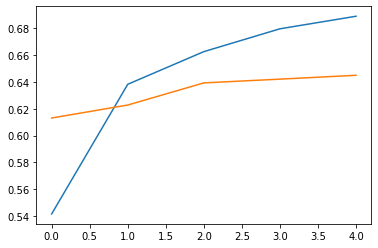

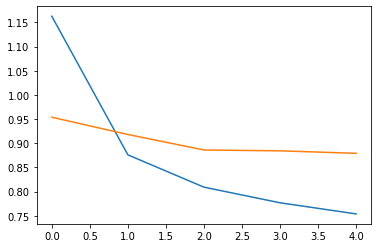

In [ ]:
import matplotlib.pyplot as plt

print(hist.history.keys())

plt.plot(hist.history['categorical_accuracy'])
plt.plot(hist.history['val_categorical_accuracy'])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

In [ ]:
y_pred = [row.tolist().index(max(row)) for row in model.predict(X_test)]
d = {'PhraseId':test_data['PhraseId'].tolist(), 'Sentiment':y_pred}
df = pd.DataFrame(d)

# create the csv and download it (in order to submit to Kaggle)
from google.colab import files
df.to_csv('/content/drive/My Drive/Colab Notebooks/340W_Project/data/submission.csv', index=False)
files.download('/content/drive/My Drive/Colab Notebooks/340W_Project/data/submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# show proportions of each category in your predictions
for i in range(5):
  print(str(i) + ": " + str(sum([1 if i==j else 0 for j in y_pred])/len(y_pred)))

0: 0.016020032583117117
1: 0.17326374223134014
2: 0.5903125565679117
3: 0.17917697459723647
4: 0.04122669402039462


In [ ]:
# see how the model does on predicting differen tags
valid_preds = [row.tolist().index(max(row)) for row in model.predict(X_valid)]
valid_truth = [row.tolist().index(1) for row in y_valid]
mistakes = {}
total = {}
for i in range(len(valid_preds)):
  if valid_preds[i] != valid_truth[i]:
    if valid_truth[i] not in mistakes:
      mistakes.update({valid_truth[i]: 1})
    else:
      mistakes[valid_truth[i]] += 1
  if valid_truth[i] not in total:
    total.update({valid_truth[i]: 1})
  else:
    total[valid_truth[i]] += 1

for sentiment in range(5):
  print("accuracy for sentiment " + str(sentiment) + ": " + str(1 - (mistakes[sentiment]/total[sentiment])))

print("overall accuracy: " + str(1-(sum(list(mistakes.values()))/sum(list(total.values())))))

accuracy for sentiment 0: 0.2466734902763562
accuracy for sentiment 1: 0.5794530672579453
accuracy for sentiment 2: 0.7923047953803666
accuracy for sentiment 3: 0.4986225895316805
accuracy for sentiment 4: 0.4035322451164035
overall accuracy: 0.6450243496091247
